# Energy efficient parallel programming

*TO DO - remove implementation*

**Note:** this notebook is meant to be executed on the supplied Docker image.

**Aim:** The aim of this notebook is to present energy efficient programming methods and relation between execution time and used energy.

In [1]:
%pip install matplotlib

     |████████████████████████████████| 11.6 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 6.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from pathlib import Path
import time

import matplotlib.pyplot as plt

## RAPL sysfs Interface


### CPU zone in sysfs

First of all, it's important to find the zone of your CPU in sysfs. Use the knowledge from the previous modules to find the path of thiz zone and complete the code below.

Please verify your path to the RAPL module in your PC.


In [2]:
cpu_zone = '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0/'

Let's verify whether this zone seems like the zone of your CPU.

In [3]:
if os.path.isdir(cpu_zone):
    print('✓ Zone exists')
else:
    print('✗ Zone does not exist!')

name = Path(f'{cpu_zone}/name').read_text().strip()

if name.startswith('package-'):
    print('✓ Its name starts with \'package-\'')
else:
    print('✗ Its zone does not start with \'package-\'!')

if os.path.isfile(f'{cpu_zone}/energy_uj'):
    print('✓ File \'energy_uj\' exists')
else:
    print('✗ File \'energy_uj\' does not exist!')

✓ Zone exists
✓ Its name starts with 'package-'
✓ File 'energy_uj' exists


### Energy consumption measurements

The energy counter which reports energy consumed by the zone in micro joules is available as a file named `energy_uj`. This file returns the energy consumed from ar arbitrary, but fixed point in time. By calculating the difference between these values at different points in time, we can obtain the energy consumed during the measurement period.


Let's start with rading the value of `energy_uj`. Complete the following code.

In [4]:
def energy_uj():
    # TO DO - remove implementation
    fp = open(f'{cpu_zone}energy_uj', 'r')
    return int(fp.read())

print(f'Current energy counter value: {energy_uj()}')

Current energy counter value: 148808260712


Next, we can use the energy counter value read at two different times to calculate energy consumption during the measurement period. Complete the following code. Remembebr that the counter may be reset to zero!


In [5]:
def energy_consumption(energy_uj_start, energy_uj_end):
    # TO DO - remove implementation
    fp = open(f'{cpu_zone}max_energy_range_uj', 'r')
    max_energy_range_uj = int(fp.read())

    if energy_uj_end < energy_uj_start:
        return max_energy_range_uj-energy_uj_start+energy_uj_end
    return energy_uj_end-energy_uj_start

Let's verify whether the function defined above works. Check the output of the script below.

In [6]:
energy = energy_consumption(10000, 10000)
if energy == 0:
    print('✓ Pass')
else:
    print(f'✗ Fail: {energy}')

energy = energy_consumption(0, 10000)
if energy == 10000:
    print('✓ Pass')
else:
    print(f'✗ Fail: {energy}')

counter_max = int(Path(f'{cpu_zone}/max_energy_range_uj').read_text().strip())
energy = energy_consumption(counter_max - 1000, 1000)
if energy == 2000:
    print('✓ Pass')
else:
    print(f'✗ Fail: {energy}')

✓ Pass
✓ Pass
✓ Pass


### Energy consumption measurement - example

Let's try measuring idle CPU energy consumption using the functions `energy_uj()` and `energy_consumption()`. Complete the following code to get the energy consumed during the 5 second measurement period in joules.

In [7]:
measure_time = 5  # seconds

# TO DO - remove implementation
start_energy_uj = energy_uj()
time.sleep(measure_time)
end_energy_uj = energy_uj()

energy_consumed_uj = energy_consumption(start_energy_uj, end_energy_uj)
energy_consumed_j = energy_consumed_uj / 10**6 / measure_time

print(f'Energy consumed: {energy_consumed_j} J')

Energy consumed: 5.0686881999999995 J


The energy consumed should be roughly between 10 and 1000 joules depending on the power of your equipment.

**Note**: If you use the ultrabook with low energy consumprion CPU like [Intel® Core™ i7-1165G7](https://ark.intel.com/content/www/us/en/ark/products/208921/intel-core-i7-1165g7-processor-12m-cache-up-to-4-70-ghz-with-ipu.html) the consumed energy may be below 10 joules

### Modifications of power limits

Verify the usage after power capping. Write the function to read power caps and power profile names.

In the following files you should read:
1. `constraint_{i}_power_limit_uw`
2. `constraint_{i}_max_power_uw`
3. `constraint_{i}_time_window_us`
4. `constraint_{i}_name`

**Tip:** your method may be similar to `energy_uj()`<br>
**Note:** you can have more than one profiles


In [8]:
def read_power_limit(constraint_num: int):
    fp_name = open(f'{cpu_zone}constraint_{constraint_num}_name', 'r')
    fp_limit = open(f'{cpu_zone}constraint_{constraint_num}_power_limit_uw', 'r')
    fp_max = open(f'{cpu_zone}constraint_{constraint_num}_max_power_uw', 'r')
    fp_time = open(f'{cpu_zone}constraint_{constraint_num}_time_window_us', 'r')

    power_limit = fp_limit.read()
    print(f"Name: {fp_name.read()[:-1]}\nPower limit: {power_limit[:-1]} [uw]\nMax limit: {fp_max.read()[:-1]} [uw]\nTime window: {fp_time.read()[:-1]} [us]")

    return power_limit

Verify your implementation:

In [9]:
init_power_limit_0 = read_power_limit(0)
init_power_limit_1 = read_power_limit(1)

Name: long_term
Power limit: 200000000 [uw]
Max limit: 45000000 [uw]
Time window: 31981568 [us]
Name: short_term
Power limit: 90000000 [uw]
Max limit: 0 [uw]
Time window: 2440 [us]


Now change the power limits. Implement the methods below. Note the provided power limits are in µW (microWatts) 1W = 1 000 000 µW 

In [10]:
def change_power_limits_uw(
    constraint_num: int,
    new_power_val: int,
    verbose: bool = False
):
    # fp = open(cpu_zone+f'constraint_{constraint_num}_power_limit_uw', 'w')
    # fp.write(f"{new_power_val}\n")

    os.system(f'echo >{cpu_zone}/constraint_{constraint_num}_power_limit_uw {new_power_val}')
    
    if verbose:
        print(f"The constraint_{constraint_num}_power_limit_uw was changed to {new_power_val}\n")
    return
    

Verify if the power limit has changed.

Be very **careful**!\
Remember old values for changed constraint!\
**Do not decrease** the value too much!

In [11]:
constraint_num = 1
new_power_limit = 50000000


print("Before changing")
read_power_limit(constraint_num=constraint_num)

change_power_limits_uw(constraint_num=constraint_num, new_power_val=new_power_limit, verbose=True)

print("After changing")
read_power_limit(constraint_num=constraint_num)

# Change power limit to initial state
change_power_limits_uw(constraint_num=constraint_num, new_power_val=init_power_limit_1, verbose=True)

Before changing
Name: short_term
Power limit: 90000000 [uw]
Max limit: 0 [uw]
Time window: 2440 [us]
The constraint_1_power_limit_uw was changed to 50000000

After changing
Name: short_term
Power limit: 50000000 [uw]
Max limit: 0 [uw]
Time window: 2440 [us]
The constraint_1_power_limit_uw was changed to 90000000




### Powercapping - analysis

In [12]:
def edp(E, T):
    """ Calculate EDP metric 

        E: energy consumption depending on power limit [J]
        T: execution time depending on power limit [s]
    """
    return E * T

def draw_power_plot(E, T, P):
    """ 
    Draw plots (3 subplots) E(power_limit), T(power_limit), P(power_limit)
    
        E: energy consumption depending on power limit [J]
        T: execution time depending on power limit [s]
        P: power limits [W]
    """

    fig, ax = plt.subplots()

    fig.suptitle("Power usage depending on set power limit")

    ax.scatter(P, E/T)
    ax.set_ylabel("Power [W]")
    ax.set_xlabel("Power limit [W]")

    plt.show()


def draw_energy_plots(E, T, P):
    """ 
    Draw plots (3 subplots) E(power_limit), T(power_limit), P(power_limit)
    
        E: energy consumption depending on power limit [J]
        T: execution time depending on power limit [s]
        P: power limits [W]
    """

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    fig.suptitle("Power capping - measurements")

    ax[0].scatter(P, E)
    ax[0].set_ylabel("Energy [J]")
    ax[0].set_xlabel("Power limit [W]")

    ax[1].scatter(P, T)
    ax[1].set_ylabel("Time [s]")
    ax[1].set_xlabel("Power limit [W]")
    
    ax[2].scatter(P, edp(E, T))
    ax[2].set_ylabel("EDP")
    ax[2].set_xlabel("Power limit [W]")

    plt.show()

## Energy efficiency and power consumption measurements based on matrix multiplication

First problem that we are going to measure efficiency is matrix multiplication. In this task we are going to use Numpy library that implements quick matrix multiplication with parallelism.  

In [13]:
import numpy as np

In [14]:
def np_test(a, b):
    " Create a test for Numpy's matrix multiplication "
    
    start_energy = energy_uj()
    start_time = time.time()
    c = a @ b
    finish_time = time.time()
    end_energy = energy_uj()

    energy_consumed = energy_consumption(start_energy, end_energy)
    return finish_time - start_time, energy_consumed / 1e6

Define power limits (at least 5 different) that you're going to set and make tests.

In [15]:
power_limits = [int(i*1e7) for i in range(2, 10)]
print(power_limits)
n_power_limits = len(power_limits)

[20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000]


Run tests and analyse the results.

In [16]:
matrix_size = 10000
n_tests = 5

np.random.seed(42)
test_matrices = [(np.random.rand(matrix_size, matrix_size), np.random.rand(matrix_size, matrix_size))for _ in range(n_tests)]

ex_time = np.zeros((n_power_limits, n_tests))
energy = np.zeros((n_power_limits, n_tests))

idx = 0
for limit in power_limits:
    change_power_limits_uw(1, limit)

    # av_time = []
    # av_energy = []
    for i in range(n_tests):

        t, energy_consumed_j = np_test(test_matrices[i][0], test_matrices[i][1])

        ex_time[idx][i] = t
        energy[idx][i] = energy_consumed_j

    # ex_time[idx] = av_time/n_tests
    # energy[idx] = av_energy/n_tests
    idx += 1

change_power_limits_uw(1,init_power_limit_1)

KeyboardInterrupt: 

In [ ]:
print(ex_time)
print(energy)

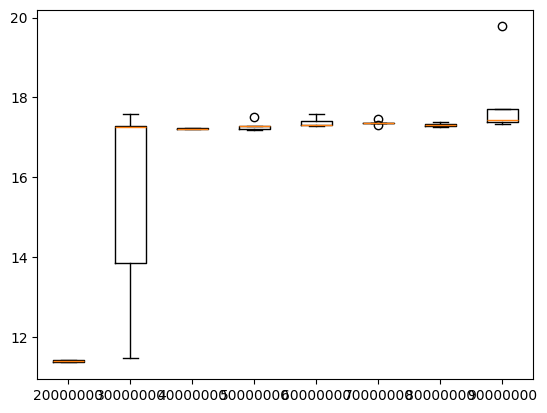

In [69]:
plt.boxplot(ex_time.T, labels=power_limits)
plt.show()

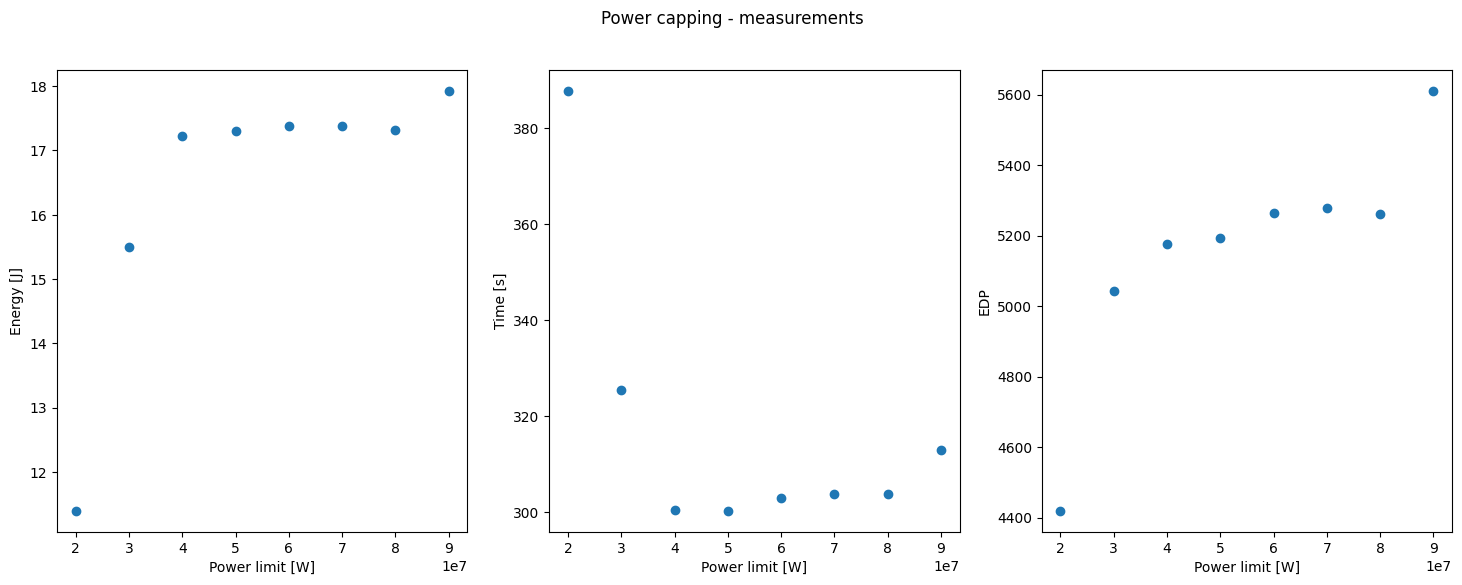

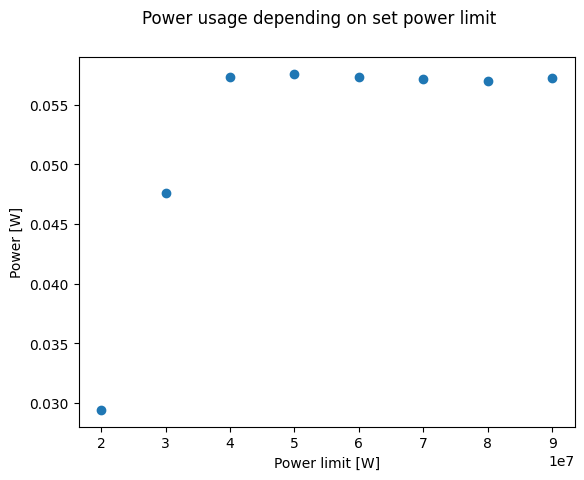

In [70]:
draw_energy_plots(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)
draw_power_plot(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)

## Energy efficiency and power consumption measurements based on graph algorithms 


Implement a function that will test energy efficiency of a given bfs and dfs algorithms.

In [33]:
import networkx as nx
import numpy as np

def test_graph_bfs(graph):
    start_energy_uj = energy_uj()
    start_ts = time.time()
    
    bfs_result = nx.bfs_tree(graph, source=0)
    
    finish_ts = time.time()
    end_energy_uj = energy_uj()
    
    energy_consumed_uj = energy_consumption(start_energy_uj, end_energy_uj)
    energy_consumed_j = energy_consumed_uj / 10**6

    return finish_ts-start_ts, energy_consumed_j

def test_graph_dfs(graph):
    start_energy_uj = energy_uj()
    start_ts = time.time()

    start_node = 1
    dfs_result = nx.dfs_tree(graph, source=0)
    
    finish_ts = time.time()
    end_energy_uj = energy_uj()

    energy_consumed_uj = energy_consumption(start_energy_uj, end_energy_uj)
    energy_consumed_j = energy_consumed_uj / 10**6

    return finish_ts-start_ts, energy_consumed_j

Based on the example code find the the used energy during calculation BFS and DFS.

Use decreasing power limit (at least 5 different limits). Measure times. What are your thoughts? 

In [34]:
power_limits = [int(i*1e7) for i in range(2, 10)]
print(power_limits)
n_power_limits = len(power_limits)

[20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000]


### BFS measurements

In [36]:
n_tests = 10

ex_time = np.zeros((n_power_limits, n_tests))
energy = np.zeros((n_power_limits, n_tests))

G = nx.random_internet_as_graph(int(5e4), seed=42)

idx = 0
for limit in power_limits:
    change_power_limits_uw(1, limit)

    for i in range(n_tests):

        t, energy_consumed_j = test_graph_bfs(G)

        ex_time[idx][i] = t
        energy[idx][i] = energy_consumed_j

    idx += 1

change_power_limits_uw(1,init_power_limit_1)

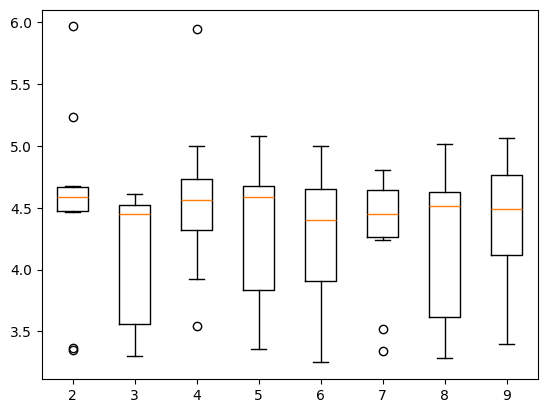

In [37]:
plt.boxplot(energy.T, labels=[i for i in range(2, 10)])
plt.show()

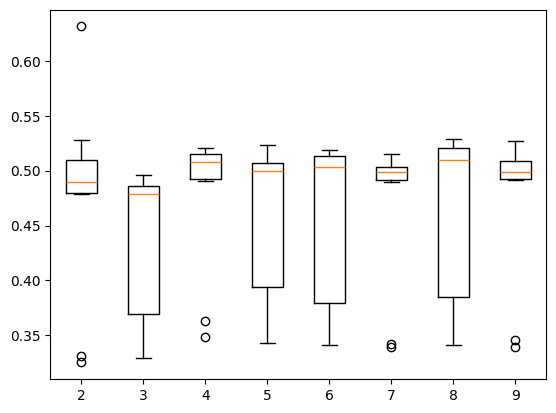

In [38]:
plt.boxplot(ex_time.T, labels=[i for i in range(2, 10)])
plt.show()

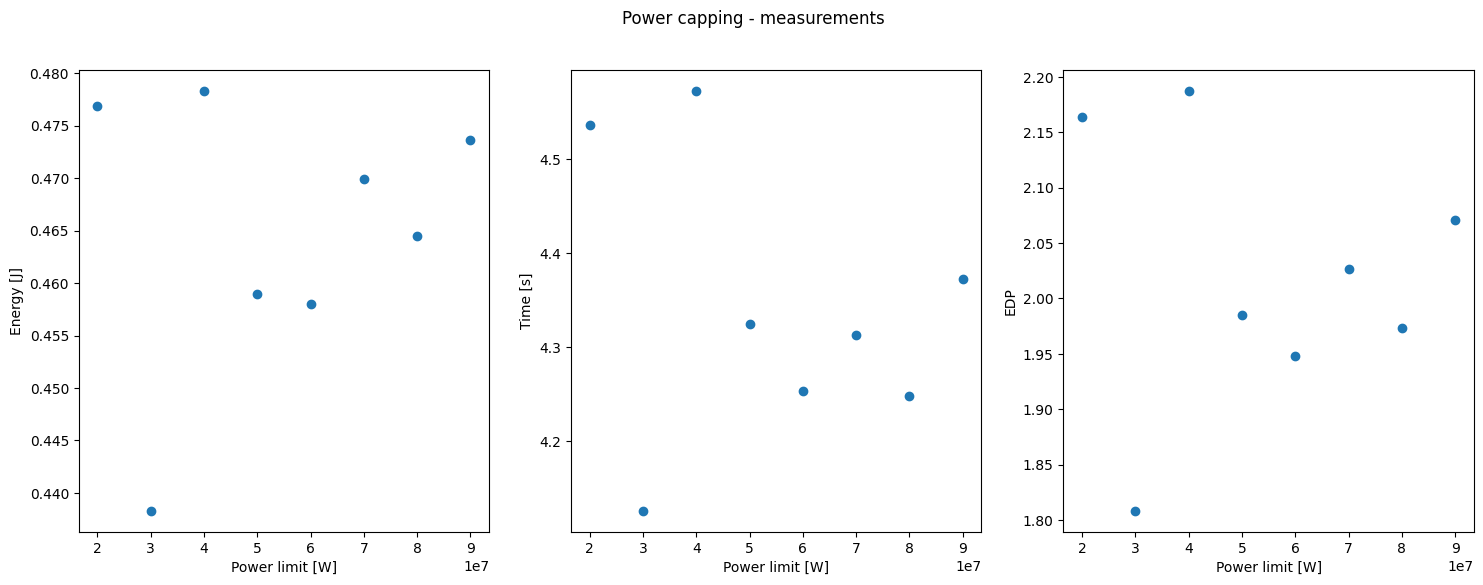

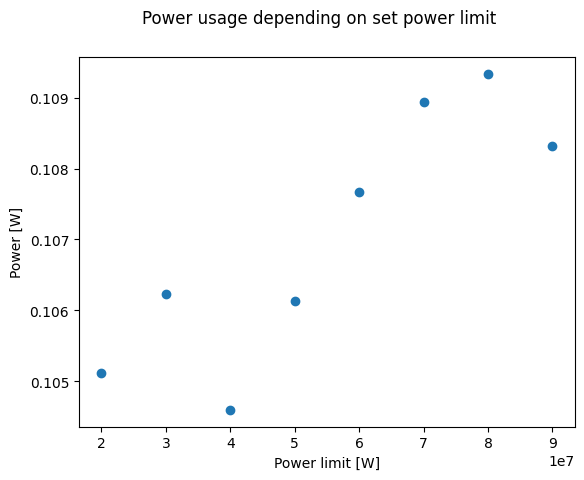

In [39]:
draw_energy_plots(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)
draw_power_plot(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)

### DFS measurements

In [40]:
import numpy as np

n_tests = 10

ex_time = np.zeros((n_power_limits, n_tests))
energy = np.zeros((n_power_limits, n_tests))

G = nx.random_internet_as_graph(int(5e4), seed=42)

idx = 0
for limit in power_limits:
    change_power_limits_uw(1, limit)

    for i in range(n_tests):

        t, energy_consumed_j = test_graph_dfs(G)

        ex_time[idx][i] = t
        energy[idx][i] = energy_consumed_j

    idx += 1

change_power_limits_uw(1,init_power_limit_1)

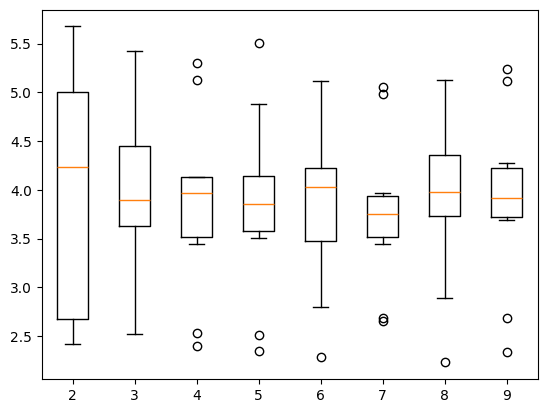

In [41]:
plt.boxplot(energy.T, labels=[i for i in range(2, 10)])
plt.show()

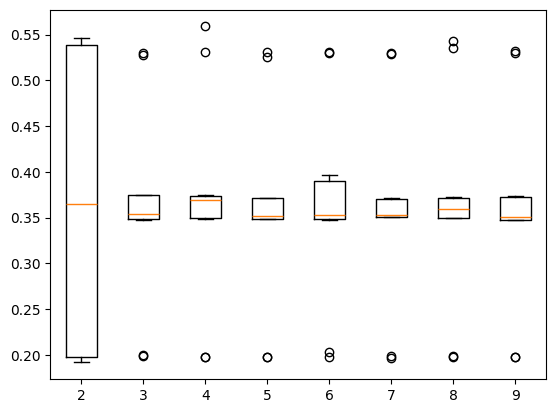

In [42]:
plt.boxplot(ex_time.T, labels=[i for i in range(2, 10)])
plt.show()

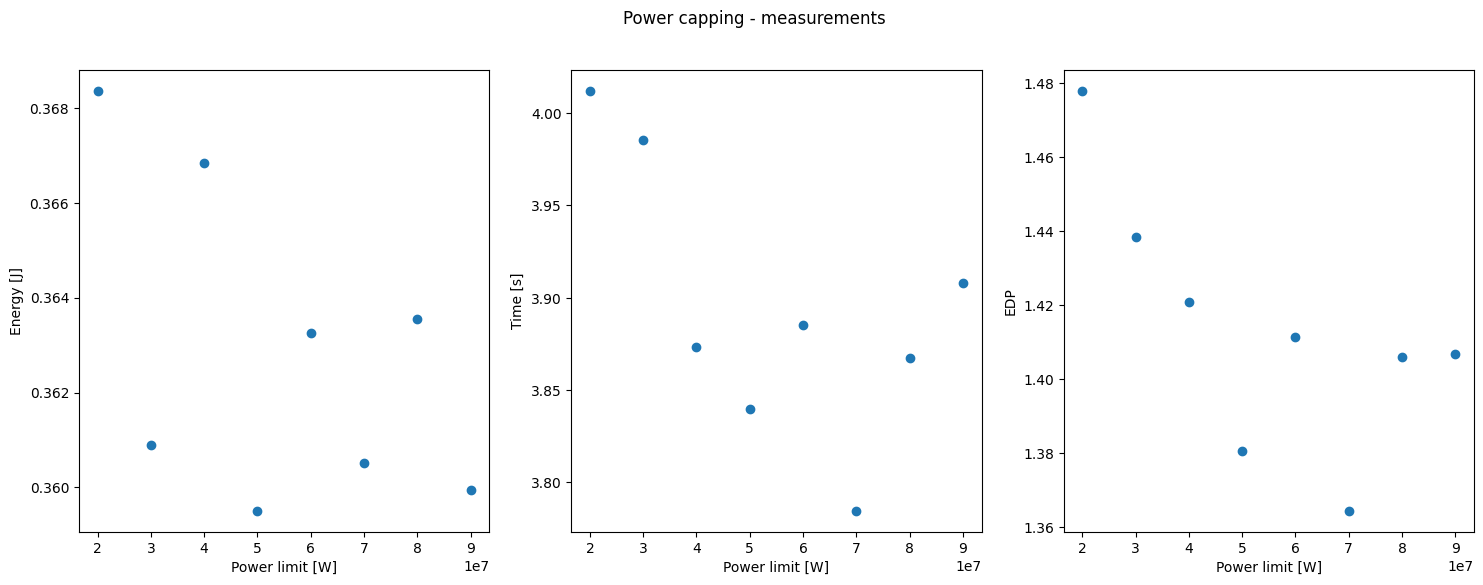

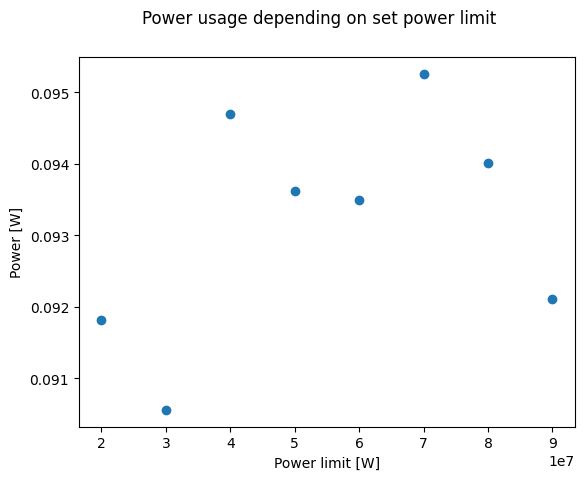

In [43]:
draw_energy_plots(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)
draw_power_plot(ex_time.mean(axis=1), energy.mean(axis=1), power_limits)